In [0]:
#https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import optimizers
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os

%matplotlib inline

In [25]:
import urllib.request


with urllib.request.urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data') as file:
    data =  pd.read_csv(file, header=None)

# extractig column names from description
names_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.names'

import requests
r = requests.get(names_url)

import re

columns = re.findall(r'\@attribute (\w*)', r.text)
del r

data.columns = columns
data.head(10)

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,...,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.00,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,...,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.00,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,...,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.00,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,...,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.00,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,...,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.0,0.19,0.30,0.73,0.64,0.65,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.90,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,0.67,...,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.0,0.11,0.72,0.64,0.61,0.53,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
5,6,?,?,SouthPasadenacity,1,0.02,0.28,0.06,0.54,1.00,0.25,0.31,0.48,0.27,0.37,0.04,1.00,0.52,0.68,0.20,0.61,0.28,0.15,0.25,0.62,0.72,0.76,0.77,0.28,0.52,0.48,0.60,0.01,0.12,0.13,0.12,0.80,0.10,0.65,0.19,...,0.63,0.68,0.62,0.47,0.59,0.11,0.00,0.0,0.70,0.42,0.49,0.73,0.64,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.01,0.58,0.10,?,?,?,?,0.00,?,0.14
6,44,7,41500,Lincolntown,1,0.01,0.39,0.00,0.98,0.06,0.02,0.30,0.37,0.23,0.60,0.02,0.81,0.42,0.50,0.23,0.68,0.61,0.21,0.54,0.43,0.47,0.44,0.40,0.24,0.86,0.24,0.36,0.01,0.11,0.29,0.41,0.36,0.28,0.54,0.44,...,0.35,0.42,0.35,0.46,0.44,0.31,0.00,0.0,0.15,0.81,0.77,0.91,0.84,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.05,0.08,0.06,?,?,?,?,0.00,?,0.03
7,6,?,?,Selmacity,1,0.01,0.74,0.03,0.46,0.20,1.00,0.52,0.55,0.36,0.35,0.00,0.00,0.16,0.44,1.00,0.23,0.53,0.97,0.41,0.15,0.10,0.12,0.08,0.17,0.27,0.18,0.21,0.03,0.64,0.96,0.82,0.12,1.00,0.26,0.43,...,0.24,0.25,0.24,0.64,0.59,0.28,0.00,0.0,0.59,0.58,0.52,0.79,0.78,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,0.01,0.33,0.00,?,?,?,?,0.00,?,0.55
8,21,?,?,Hendersoncity,1,0.03,0.34,0.20,0.84,0.02,0.00,0.38,0.45,0.28,0.48,0.04,1.00,0.17,0.47,0.36,0.34,0.55,0.48,0.43,0.21,0.23,0.23,0.19,0.10,0.26,0.29,0

In [0]:
# Remove non-predictive features
data = data.drop(columns=['state','county',
                          'community','communityname',
                          'fold'], axis=1)

In [27]:
data = data.replace('?', np.nan)
feat_miss = data.columns[data.isnull().any()]
# Look at the features with missing values
data[feat_miss].describe()

,OtherPerCap,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,PolicBudgPerPop
count,1993,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319,319
unique,97,38,52,34,55,44,59,75,52,76,74,73,54,50,72,30,15,77,63,38,72,3,51
top,0,0.02,0.1,0.98,0.19,0.02,0.14,0.23,0.1,0.78,0.72,0,0,0,0.07,0.03,0.57,0.19,0.02,0.02,0.74,0,0.12
freq,129,80,19,81,17,55,23,15,19,12,11,23,72,189,14,48,54,12,27,69,13,126,22


In [0]:
# Remove all those features with too much missing values(50%)
cut_tresh = 0.5
to_drop = data.columns[data.count() < data.shape[0]*cut_tresh]
data = data.drop(columns=to_drop)

In [29]:
data.head() # 100 features left

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,...,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.40,...,0.06,0.14,0.13,0.33,0.39,0.28,0.55,0.09,0.51,0.5,0.21,0.71,0.52,0.05,0.26,0.65,0.14,0.06,0.22,0.19,0.18,0.36,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,0.42,0.36,1.00,0.63,...,0.10,0.16,0.10,0.17,0.29,0.17,0.26,0.20,0.82,0.0,0.02,0.79,0.24,0.02,0.25,0.65,0.16,0.00,0.21,0.20,0.21,0.42,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,0.49,0.32,0.63,0.41,...,0.04,0.20,0.20,0.46,0.52,0.43,0.42,0.15,0.51,0.5,0.01,0.86,0.41,0.29,0.30,0.52,0.47,0.45,0.18,0.17,0.16,0.27,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,0.45,0.37,0.39,0.34,0.45,...,0.08,0.56,0.62,0.85,0.77,1.00,0.94,0.12,0.01,0.5,0.01,0.97,0.96,0.60,0.47,0.52,0.11,0.11,0.24,0.21,0.19,0.75,0.70,0.77,0.89,0.63,0.51,0.47,0.00,0.0,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,0.02,0.9,0.50,0.72,0.16,0.68,0.44,0.11,0.71,0.46,0.43,0.41,0.28,0.00,0.74,0.51,0.48,0.00,0.06,0.25,0.30,0.33,0.12,0.65,0.67,0.38,0.42,0.46,0.22,0.27,...,0.05,0.16,0.19,0.59,0.60,0.37,0.89,0.02,0.19,0.5,0.01,0.89,0.87,0.04,0.55,0.73,0.05,0.14,0.31,0.31,0.30,0.40,0.36,0.38,0.38,0.22,0.51,0.21,0.00,0.0,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03


In [0]:
#The only missing value left is inside Other_per_cap feature, therefore we are going to replace it with the mean 
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

imputer = imputer.fit(data[['OtherPerCap']])
data[['OtherPerCap']] = imputer.transform(data[['OtherPerCap']])

In [31]:
from sklearn.model_selection import train_test_split

x = data.iloc[:, 0:100].values
y = data.iloc[:, 100].values

seed = 5
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = seed)
print(x_train.shape)
print(x_test.shape)

(1595, 100)
(399, 100)


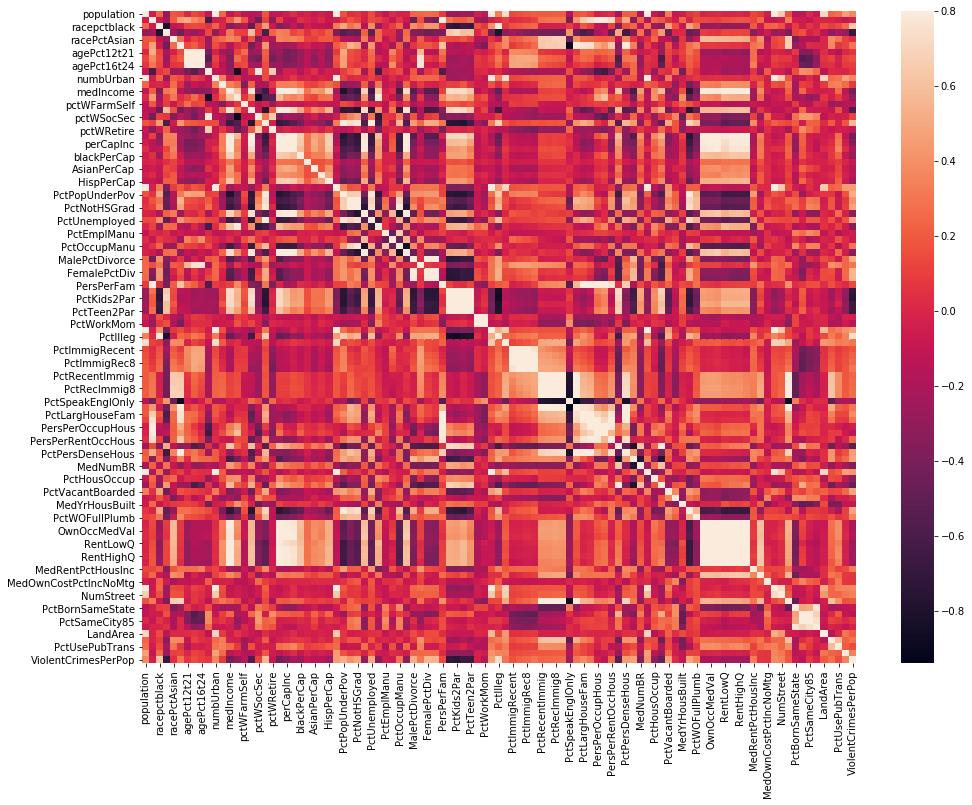

In [32]:
import seaborn as sns

corrmat = data.corr()
fig = plt.figure(figsize = (16, 12))

sns.heatmap(corrmat, vmax = 0.8)
plt.show()

In [0]:
from sklearn.preprocessing import StandardScaler

# Standardize features by removing the mean and scaling to unit variance

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

mean_squared_error: 1.94%


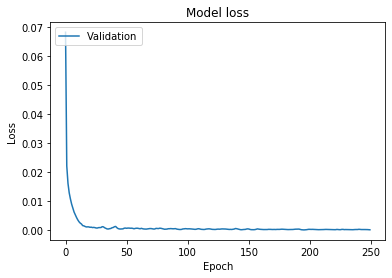

mean_squared_error: 1.75%


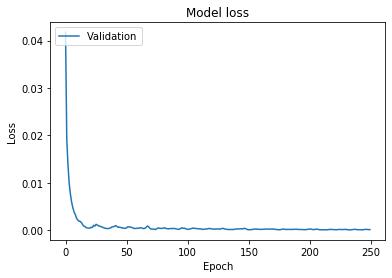

mean_squared_error: 1.88%


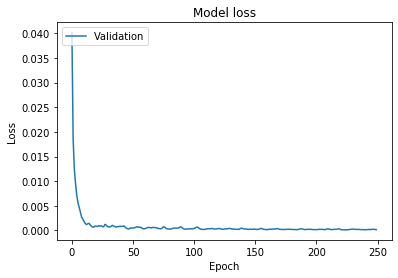

mean_squared_error: 2.00%


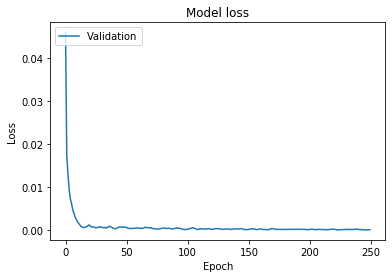

1.89% (+/- 0.09%)


In [34]:
from sklearn.model_selection import KFold
from keras.optimizers import Adam

batch_size = 50
epochs = 100

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.99, amsgrad=False)

# define 10-fold cross validation test harness
kfold = KFold(n_splits=4, shuffle=True, random_state=seed)
cvscores = []
# initiate RMSprop optimizer
sgd = keras.optimizers.SGD(lr = 0.01, decay=1e-6, momentum=0.9, nesterov=True)
for train, test in kfold.split(x_train, y_train):
  model = Sequential()
  model.add(Dense(512,input_shape=(100,),activation='relu'))
  model.add(Dense(455,activation='relu'))
  model.add(Dense(311,activation='relu'))
  model.add(Dense(178,activation='relu'))
  model.add(Dense(1,activation='linear'))
  # Compile model
  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
  # Fit the model
  history = model.fit(x_train[train], y_train[train], epochs=250, batch_size=50, verbose=0)
  # evaluate the model
  scores = model.evaluate(x_train[test], y_train[test], verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Validation'], loc='upper left')
  plt.show()
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

In [35]:
model.evaluate(x=x_test, y=y_test)

399/399 [==============================] - 0s 115us/step


[0.02208751310269934, 0.02208751310269934]

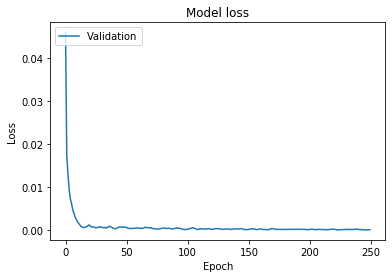

In [36]:

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

Epoch 1/250
1595/1595 [==============================] - 2s 1ms/step - loss: 0.0369 - mean_squared_error: 0.0369
Epoch 2/250
1595/1595 [==============================] - 1s 320us/step - loss: 0.0167 - mean_squared_error: 0.0167
Epoch 3/250
1595/1595 [==============================] - 0s 307us/step - loss: 0.0125 - mean_squared_error: 0.0125
Epoch 4/250
1595/1595 [==============================] - 0s 304us/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 5/250
1595/1595 [==============================] - 0s 289us/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 6/250
1595/1595 [==============================] - 0s 284us/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 7/250
1595/1595 [==============================] - 0s 281us/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 8/250
1595/1595 [==============================] - 0s 302us/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 9/250
1595/1595 [==============================] - 0s 297us/step - loss: 0.0

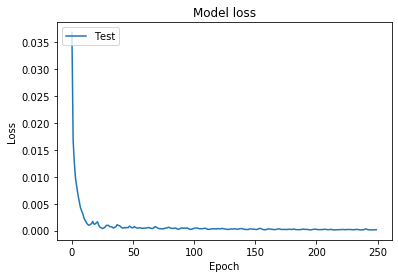

399/399 [==============================] - 1s 2ms/step
mean_squared_error: 2.06%


In [37]:
model = Sequential()
model.add(Dense(512,input_shape=(100,),activation='relu'))
model.add(Dense(455,activation='relu'))
model.add(Dense(311,activation='relu'))
model.add(Dense(178,activation='relu'))
model.add(Dense(1,activation='linear'))
# Compile model
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
# Fit the model
history = model.fit(x_train, y_train, epochs=250, batch_size=50, verbose=1)
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test'], loc='upper left')
plt.show()
# evaluate the model
scores = model.evaluate(x_test, y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [38]:
# save model
model.save("task3model.h5")
print("Saved model to disk")

Saved model to disk


In [39]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
# load model
model = load_model('task3model.h5')
# summarize model.
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 512)               51712     
_________________________________________________________________
dense_82 (Dense)             (None, 455)               233415    
_________________________________________________________________
dense_83 (Dense)             (None, 311)               141816    
_________________________________________________________________
dense_84 (Dense)             (None, 178)               55536     
_________________________________________________________________
dense_85 (Dense)             (None, 1)                 179       
Total params: 482,658
Trainable params: 482,658
Non-trainable params: 0
_________________________________________________________________
